In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px
import nbformat
import random
from scipy.optimize import curve_fit, minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import ConstantKernel, RBF
# from scipy.optimize import minimize

In [2]:
df_NO2 = pd.read_excel("df_no_null_no2.xlsx")
df_NO2

,OBJECTID,datetime,run_index,Longitude,Latitude,Elevation,hour,CO2,CO,NO,...,BCLocal,weight,site,period,season,type,date,time,year,day
0,1,2016-08-08 09:55:00,21648,-79.962249,40.441570,293.650820,9,535.973841,0.390839,19.375092,...,0.666689,3,0,1,1,3,2016-08-08,09:55:00,2016,8
1,2,2016-08-08 09:56:02,21649,-79.965543,40.443281,342.895238,9,524.337810,0.390429,15.009414,...,0.337680,3,9,1,1,3,2016-08-08,09:56:02,2016,8
2,3,2016-08-08 09:56:59,21650,-79.965617,40.445433,366.213793,9,520.587519,0.391188,19.160648,...,0.426720,3,9,1,1,3,2016-08-08,09:56:59,2016,8
3,4,2016-08-08 09:58:01,21651,-79.965430,40.446530,368.885714,9,515.956838,0.390167,11.922513,...,0.285965,3,9,1,1,3,2016-08-08,09:58:01,2016,8
4,5,2016-08-08 09:59:00,21652,-79.965450,40.446502,369.160000,9,512.491392,0.388597,10.575528,...,0.526177,3,9,1,1,3,2016-08-08,09:59:00,2016,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13372,16374,2017-02-17 14:11:05,173848,-79.942654,40.441972,288.300000,14,449.007345,0.133736,6.618564,...,0.015426,1,0,2,3,1,2017-02-17,14:11:05,2017,17
13373,16375,2017-02-17 14:11:26,173849,-79.942654,40.441972,288.304546,14,448.803000,0.131727,6.060195,...,0.442616,1,0,2,3,1,2017-02-17,14:11:26,2017,17
13374,16376,2017-02-17 14:11:47,173850,-79.942652,40.441973,288.400000,14,451.573027,0.129591,5.687600,...,-0.296266,1,0,2,3,1,2017-02-17,14:11:47,2017,17
13375,16377,2017-02-17 14:12:08,173851,-79.942652,40.441975,288.704545,14,460.432423,0.127355,5.113914,...,0.299189,1,0,2,3,1,2017-02-17,14:12:08,2017,17


In [3]:
df_NO2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13377 entries, 0 to 13376
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OBJECTID           13377 non-null  int64         
 1   datetime           13377 non-null  datetime64[ns]
 2   run_index          13377 non-null  int64         
 3   Longitude          13377 non-null  float64       
 4   Latitude           13377 non-null  float64       
 5   Elevation          13074 non-null  float64       
 6   hour               13377 non-null  int64         
 7   CO2                13287 non-null  float64       
 8   CO                 13377 non-null  float64       
 9   NO                 13377 non-null  float64       
 10  NO2                13377 non-null  float64       
 11  NOx                13377 non-null  float64       
 12  matlab_date        13377 non-null  int64         
 13  month              13377 non-null  int64         
 14  PageNa

## Fitting daily sin function

### Data split

In [4]:
# Creating train and validation sets


In [5]:
df_trainval = df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]
df_trainval.shape

(11845, 51)

In [6]:
# number of samples to include in validation set
11845*0.2

2369.0

In [7]:
# Creating a validation set
df_val = df_trainval[(df_NO2["day"] >= 6) & (df_NO2["month"] == 2)]
df_val.shape

/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_74125/2241982675.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_val = df_trainval[(df_NO2["day"] >= 6) & (df_NO2["month"] == 2)]


(2260, 51)

In [8]:
# Creating a training set
df_train = df_trainval[(df_NO2["day"] < 6) | (df_NO2["month"] != 2)]
df_train.shape

/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_74125/60061332.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_trainval[(df_NO2["day"] < 6) | (df_NO2["month"] != 2)]


(9585, 51)

In [2]:
# Use the new splits
df_train = pd.read_csv('train_val_split/observation_filtered.csv')
df_val = pd.read_csv('train_val_split/validation_filtered.csv')

### Visualization of the training data

In [3]:
daily_NO2 = df_train.groupby(['year', 'month', 'day']).agg({'NO2': list, 'time': list}).reset_index()

In [4]:
daily_NO2

,year,month,day,NO2,time
0,2016,8,8,"[15.98284677, 15.56804167, 17.60913226, 12.955...","[10:27:01, 10:37:00, 10:31:01, 10:18:02, 10:51..."
1,2016,8,9,"[0.603774194, 11.02025645, 8.957944444, 6.5835...","[04:47:01, 03:38:00, 03:45:01, 04:58:00, 03:42..."
2,2016,8,11,"[10.016775, 2.045595161, 0.795801613, 7.080085...","[04:07:00, 07:42:01, 06:23:01, 07:24:01, 08:48..."
3,2016,8,12,"[8.822545, 0.813329032, 1.940755738, 1.3146271...","[06:50:01, 07:44:01, 06:16:01, 06:45:00, 04:54..."
4,2016,8,15,"[10.69697213, 7.382659677, 11.90744754, 3.5641...","[17:57:01, 20:40:02, 17:41:01, 19:04:00, 17:55..."
5,2016,8,17,"[0.021534921, 0.061930508, 0.672819672, 0.3878...","[17:27:01, 17:31:59, 19:18:01, 19:20:01, 17:36..."
6,2016,9,13,"[2.65025082, 14.73024918, 4.043321311, 12.4611...","[19:48:01, 21:25:00, 20:18:00, 18:52:59, 20:47..."
7,2016,9,15,"[7.99437541, 3.86624, 5.966404839, 4.887839344...","[10:26:01, 06:22:00, 07:37:00, 10:50:01, 09:45..."
8,2016,9,20,"[16.49511356, 4.5599, 0.376681667, 5.744227869...","[20:57:59, 18:03:00, 21:45:59, 18:55:00, 21:32..."
9,2016,9,22,"[23.97678525, 0.174970492, 4.256318033, 20.595...","[14:05:03, 13:29:03, 14:35:03, 13:44:03, 13:45..."


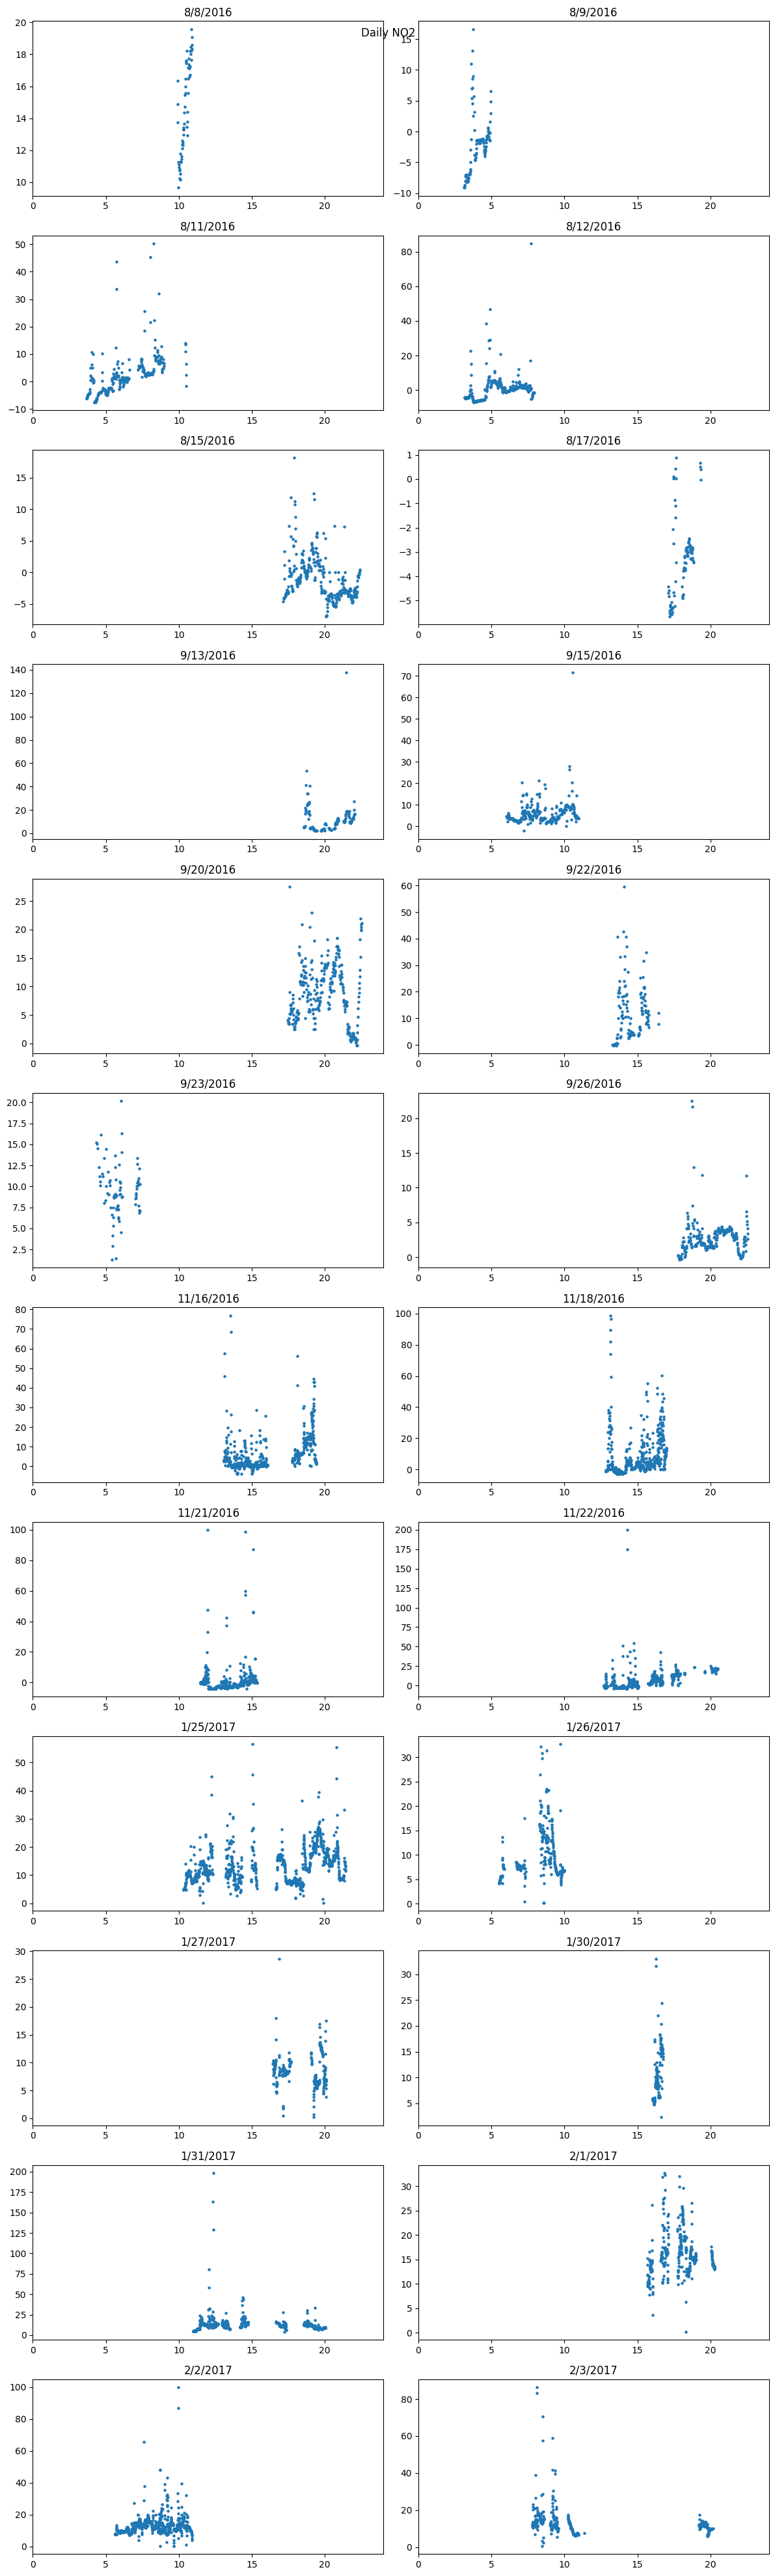

In [11]:
# Daily NO2 visualization for each of the 29 days

fig, axs = plt.subplots(12, 2, figsize=(12, 40))
fig.suptitle("Daily NO2")

for i in range(12):
    for j in range(2):
        subplot_index = i * 2 + j
        idx_row = daily_NO2.iloc[subplot_index]
        timestamps = idx_row['time']
        times_numeric = [int(time.split(':')[0]) + int(time.split(':')[1]) / 60 for time in timestamps]
        NO2 = idx_row['NO2']
        ax = axs[i, j]
        ax.scatter(times_numeric, NO2, s=5)
        ax.set_title(f"{idx_row['month']}/{idx_row['day']}/{idx_row['year']}")
        ax.set_xlim(0, 24)
        # ax.set_ylim(y_min, y_max)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

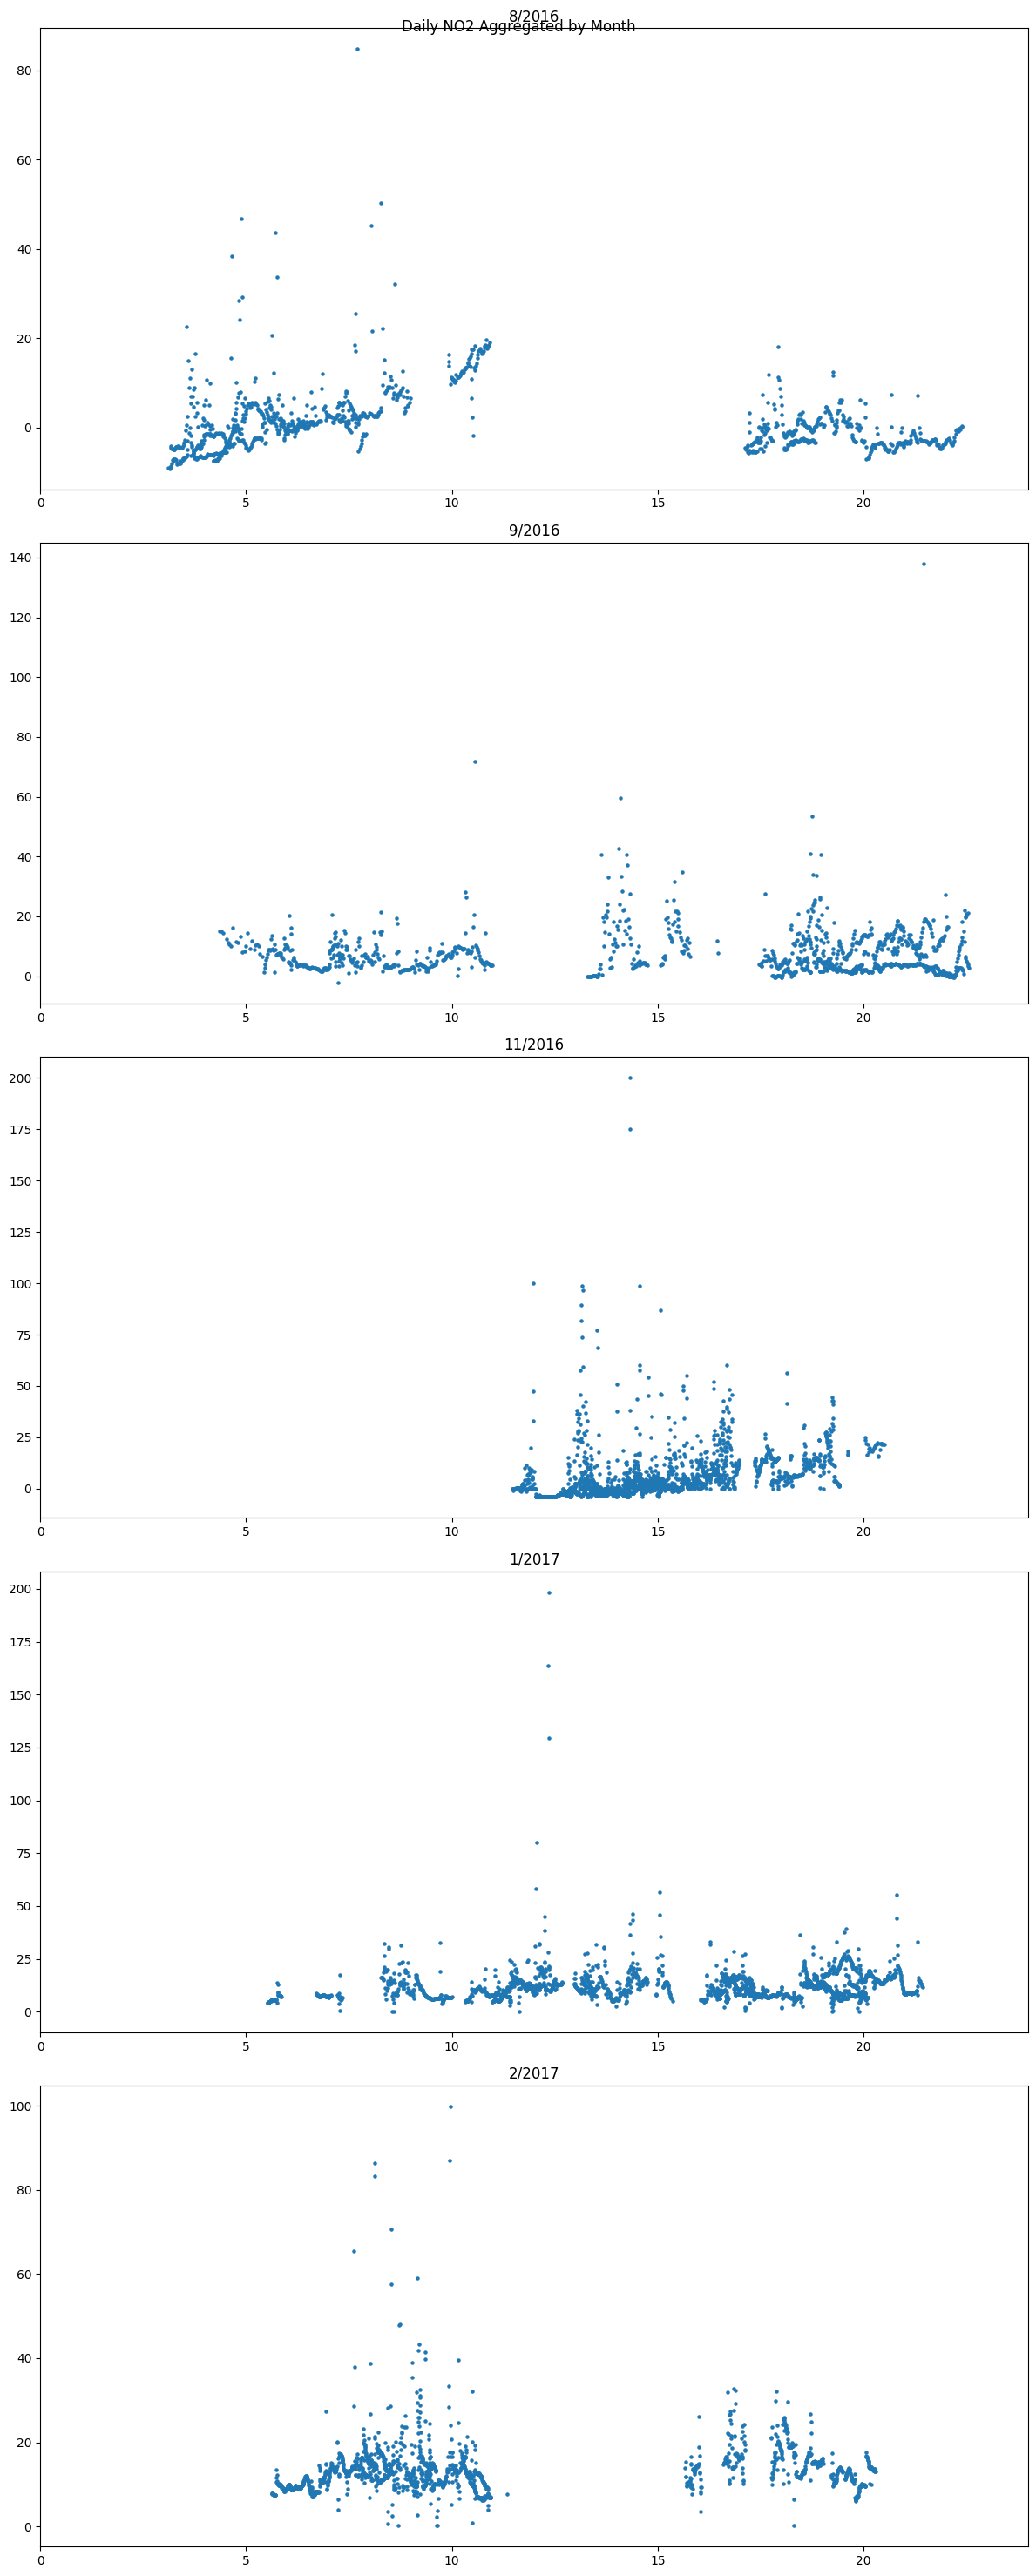

In [12]:
# Daily NO2 visualization aggregated by month
daily_NO2_agg_by_month = daily_NO2.groupby(['year', 'month']).agg({'NO2': list, 'time': list}).reset_index()

fig, axs = plt.subplots(5, 1, figsize=(12, 30))
fig.suptitle("Daily NO2 Aggregated by Month")

for i in range(5):
    idx_row = daily_NO2_agg_by_month.iloc[i]
    timestamps_lists = idx_row['time']
    timestamps = [item for sublist in timestamps_lists for item in sublist]
    times_numeric = [int(time.split(':')[0]) + int(time.split(':')[1]) / 60 for time in timestamps]
    NO2_lists = idx_row['NO2']
    NO2 = [item for sublist in NO2_lists for item in sublist]
    ax = axs[i]
    ax.scatter(times_numeric, NO2, s=5)
    ax.set_title(f"{idx_row['month']}/{idx_row['year']}")
    ax.set_xlim(0, 24)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

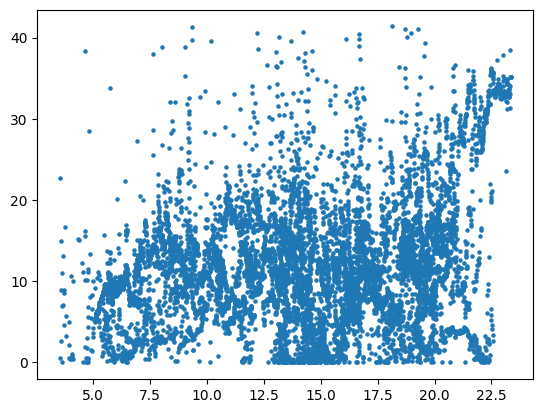

In [5]:
# Daily NO2 visualization aggregated across all dates
flattened_NO2 = daily_NO2['NO2'].explode().tolist()
flattened_time = daily_NO2['time'].explode().tolist()

flattened_times_numeric = [int(time.split(':')[0]) + int(time.split(':')[1]) / 60 for time in flattened_time]
plt.scatter(flattened_times_numeric, flattened_NO2, s=5)

In [6]:
flattened_time = np.array(flattened_time)

# Drop values that are below 0
filtered_NO2 = [value for value in flattened_NO2 if value >= 0]
filtered_idx = [index for index, value in enumerate(flattened_NO2) if value >= 0]
filtered_time = flattened_time[filtered_idx]

# Filter out outliers that are more than three SD away
mean_value = np.mean(filtered_NO2)
std_deviation = np.std(filtered_NO2)

value_3std = mean_value + 3 * std_deviation

print("Mean:", mean_value)
print("Standard Deviation:", std_deviation)
print("Value at 3 Standard Deviations:", value_3std)


In [15]:
filtered_NO2 = [value for value in filtered_NO2 if value < value_3std]
filtered_idx = [index for index, value in enumerate(filtered_NO2) if value < value_3std]
filtered_time = filtered_time[filtered_idx]

In [7]:
# Same procedure for validation data for later
daily_NO2_val = df_val.groupby(['year', 'month', 'day']).agg({'NO2': list, 'time': list}).reset_index()
flattened_NO2_val = daily_NO2_val['NO2'].explode().tolist()
flattened_time_val = daily_NO2_val['time'].explode().tolist()
flattened_time_val = np.array(flattened_time_val)

filtered_NO2_val = [value for value in flattened_NO2_val if value >= 0]
filtered_idx_val = [index for index, value in enumerate(flattened_NO2_val) if value >= 0]
filtered_time_val = flattened_time_val[filtered_idx_val]

filtered_NO2_val = [value for value in filtered_NO2_val if value < value_3std]
filtered_idx_val = [index for index, value in enumerate(filtered_NO2_val) if value < value_3std]
filtered_time_val = filtered_time_val[filtered_idx_val]

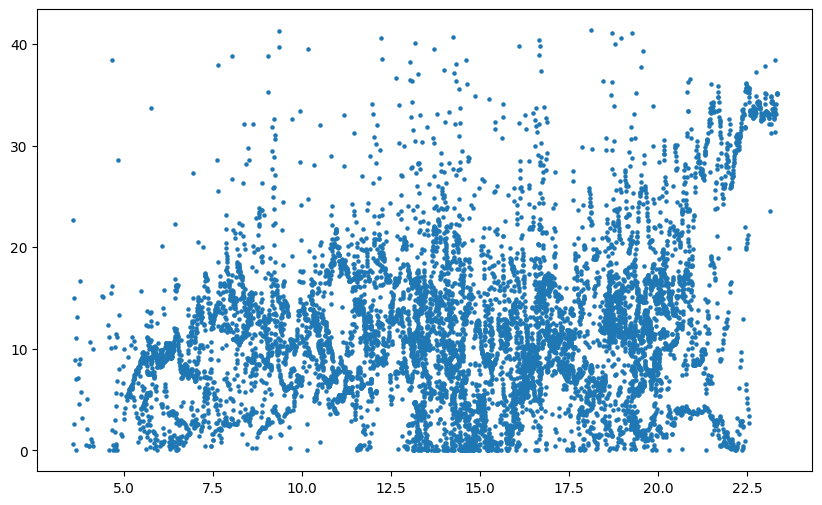

In [8]:
plt.figure(figsize=(10, 6))
filtered_time_numeric = [int(time.split(':')[0]) + int(time.split(':')[1]) / 60 for time in filtered_time]
plt.scatter(filtered_time_numeric, filtered_NO2, s=5)

MSE of hand-tuned period function: 139.23380916884437


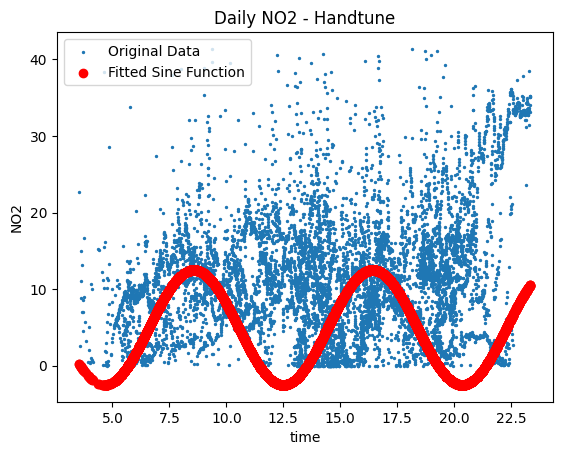

In [9]:
# HANDTUNE - Define the sine function to fit - Use this for initialization for fit_curve
def daily_trend(t, amplitude, frequency, phase, offset):
    t = np.array(t)
    return amplitude * np.sin(frequency * t + phase) + offset

# Fit the sine function to the data
param_guess = (7.5, 0.8, 1, 5)  # Initial guess for amplitude, frequency, phase, and offset

# Generate the fitted curve
y_fit = daily_trend(filtered_time_numeric, *param_guess)

# Calculate the residuals (difference between observed and predicted values)
residuals = filtered_NO2 - y_fit

# Calculate the sum of squared residuals
mse = np.mean(residuals**2)
print("MSE of hand-tuned period function:", mse)

# Plot the original data and the fitted sine function
plt.scatter(filtered_time_numeric, filtered_NO2, label='Original Data', s=2)
plt.scatter(filtered_time_numeric, y_fit, label='Fitted Sine Function', color='red')
plt.title("Daily NO2 - Handtune")
plt.xlabel('time')
plt.ylabel('NO2')
plt.legend()
plt.show()

Optimized parameters: [-2.69653951  0.56334317  4.95417444 11.74590829]
mse=52.102 || R^2=0.062


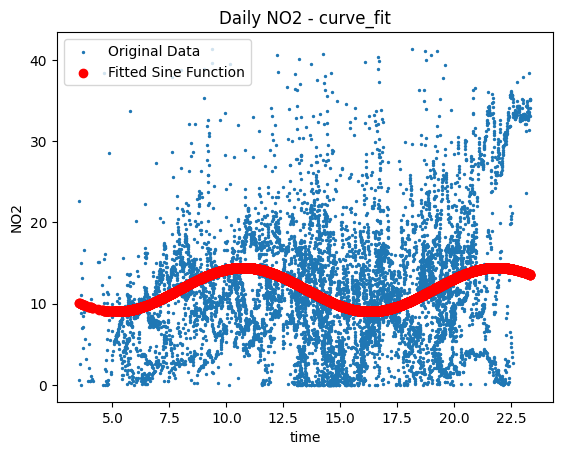

In [22]:
# Fit the sine function to the data
initial_guess = (7.5, 0.8, 1, 3.5)  # Initial guess for amplitude, frequency, phase, and offset
params, covariance = curve_fit(daily_trend, filtered_time_numeric, filtered_NO2, p0=initial_guess)
print("Optimized parameters:", params)

# Generate the fitted curve
y_fit = daily_trend(filtered_time_numeric, *params)

# Calculate the residuals (difference between observed and predicted values)
residuals = filtered_NO2 - y_fit

# Calculate metrics
mse = mean_squared_error(filtered_NO2, y_fit)
rsq = r2_score(filtered_NO2, y_fit)
print(f'mse={mse:.3f} || R^2={rsq:.3f}')

# Plot the original data and the fitted sine function
plt.scatter(filtered_time_numeric, filtered_NO2, label='Original Data', s=2)
plt.scatter(filtered_time_numeric, y_fit, label='Fitted Sine Function', color='red')
plt.title("Daily NO2 - curve_fit")
plt.xlabel('time')
plt.ylabel('NO2')
plt.legend()
plt.show()

In [23]:
# get MSE for validation
param_opt = (-2.69653951,0.56334317,4.95417444,11.74590829)

filtered_time_numeric_val = [int(time.split(':')[0]) + int(time.split(':')[1]) / 60 for time in filtered_time_val]
y_fit_val = daily_trend(filtered_time_numeric_val, *param_opt)

# Calculate the residuals (difference between observed and predicted values)
residuals_val = filtered_NO2_val - y_fit_val
# Calculate metrics
mse = mean_squared_error(filtered_NO2_val, y_fit_val)
rsq = r2_score(filtered_NO2_val, y_fit_val)
print(f'mse={mse:.3f} || R^2={rsq:.3f}')

mse=48.403 || R^2=0.069


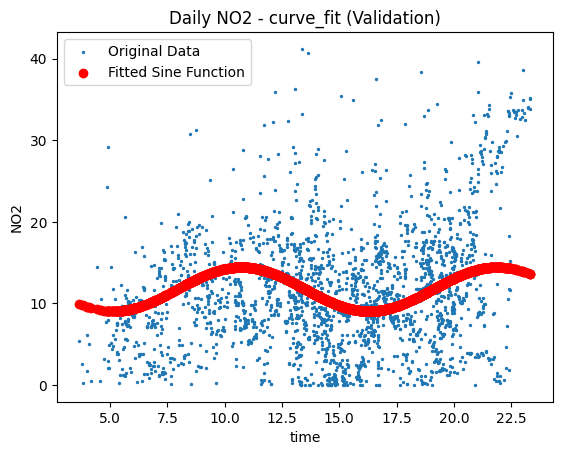

In [12]:
plt.scatter(filtered_time_numeric_val, filtered_NO2_val, label='Original Data', s=2)
plt.scatter(filtered_time_numeric_val, y_fit_val, label='Fitted Sine Function', color='red')
plt.title("Daily NO2 - curve_fit (Validation)")
plt.xlabel('time')
plt.ylabel('NO2')
plt.legend()
plt.show()

## Using Gaussian Process to fit a monthly trend

In [22]:
df_train['daily_time_index'] = df_train['time'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)
df_val['daily_time_index'] = df_val['time'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)


/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_74125/3089225577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['daily_time_index'] = df_train['time'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)
/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_74125/3089225577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['daily_time_index'] = df_val['time'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)


In [23]:
df_train = df_train.drop(df_train[df_train['NO2'] < 0].index)
df_train = df_train.drop(df_train[df_train['NO2'] >= value_3std].index)
df_val = df_val.drop(df_val[df_val['NO2'] < 0].index)
df_val = df_val.drop(df_val[df_val['NO2'] >= value_3std].index)

In [24]:
# Subtract the global mean
df_train['residual_from_global_mean'] = df_train['NO2']-daily_trend(df_train['daily_time_index'], *param_opt)
df_val['residual_from_global_mean'] = df_val['NO2']-daily_trend(df_val['daily_time_index'], *param_opt)

In [25]:
# monthly_NO2_train = df_train.groupby(['month']).agg({'residual_from_global_mean': list, 'day': list}).reset_index()
# monthly_NO2_train

In [26]:
# monthly_NO2_val = df_val.groupby(['month']).agg({'residual_from_global_mean': list, 'day': list}).reset_index()
# monthly_NO2_val

In [27]:
# Daily NO2 visualization aggregated across all dates
# flattened_NO2 = monthly_NO2['NO2'].explode().tolist()
# flattened_time = monthly_NO2['time'].explode().tolist()

# flattened_times_numeric = [int(time.split(':')[0]) + int(time.split(':')[1]) / 60 for time in flattened_time]
# plt.scatter(flattened_times_numeric, flattened_NO2, s=5)

### Fitting after aggregating into day of the month

In [28]:
X_train = df_train[['day']].values
y_train = df_train['residual_from_global_mean'].values

X_val = df_val[['day']].values
y_val = df_val['residual_from_global_mean'].values

#### RBF kernel

In [29]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.5, length_scale_bounds="fixed"), random_state=42)
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=0.5), random_state=42)

In [30]:
# Predict on training data
y_train_pred, sigma = gp.predict(X_train, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_train_pred)

print("Mean Squared Error (training):", mse)

Mean Squared Error (training): 28.741486019005357


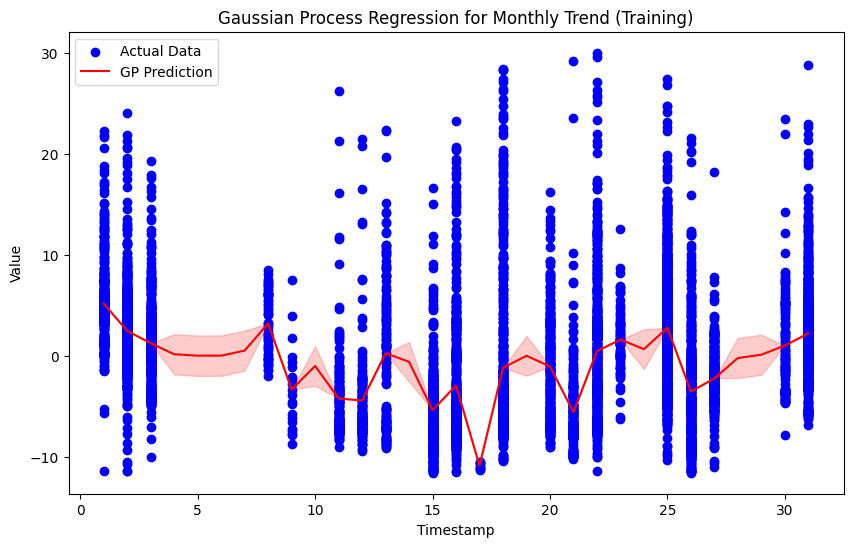

In [31]:
# Generate predictions for the entire year
train_days = np.array(range(1, 32))
train_X = [[i] for i in train_days]
y_pred, sigma = gp.predict(train_X, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_train['day'], df_train['residual_from_global_mean'], label='Actual Data', color='blue')
plt.plot(train_days, y_pred, label='GP Prediction', color='red')
plt.fill_between(train_days, y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression for Monthly Trend (Training)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [32]:
# Predict on validation data
y_val_pred, sigma = gp.predict(X_val, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_val_pred)

print("Mean Squared Error (validation):", mse)

Mean Squared Error (validation): 37.30559047546109


In [33]:
X_val

array([[ 6],
       [ 6],
       [ 6],
       ...,
       [14],
       [14],
       [14]])

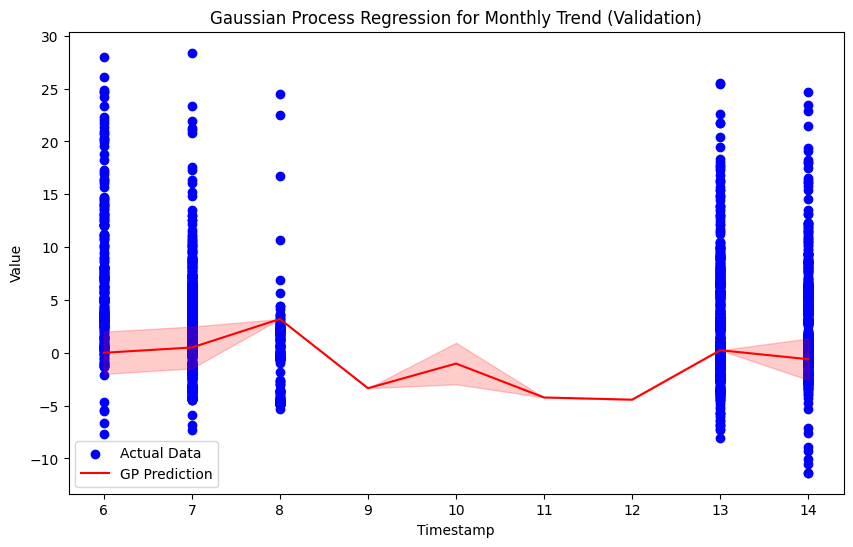

In [36]:
val_days = np.array(range(6, 15))
val_X = [[i] for i in val_days]
y_pred, sigma = gp.predict(val_X, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_val['day'], df_val['residual_from_global_mean'], label='Actual Data', color='blue')
plt.plot(val_days, y_pred, label='GP Prediction', color='red')
plt.fill_between(val_days, y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression for Monthly Trend (Validation)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

### Fitting after aggregating by the month and the day

In [55]:
X_train = df_train[['month', 'day']].values
y_train = df_train['residual_from_global_mean'].values

X_val = df_val[['month', 'day']].values
y_val = df_val['residual_from_global_mean'].values

#### Trying out different kernels

#### Option 1: RBF

In [56]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.5, length_scale_bounds="fixed"), random_state=42)
gp.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Predict on training data
y_train_pred, sigma = gp.predict(X_train, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_train_pred)

print("Mean Squared Error (training):", mse)

Mean Squared Error (training): 27.62793729452866


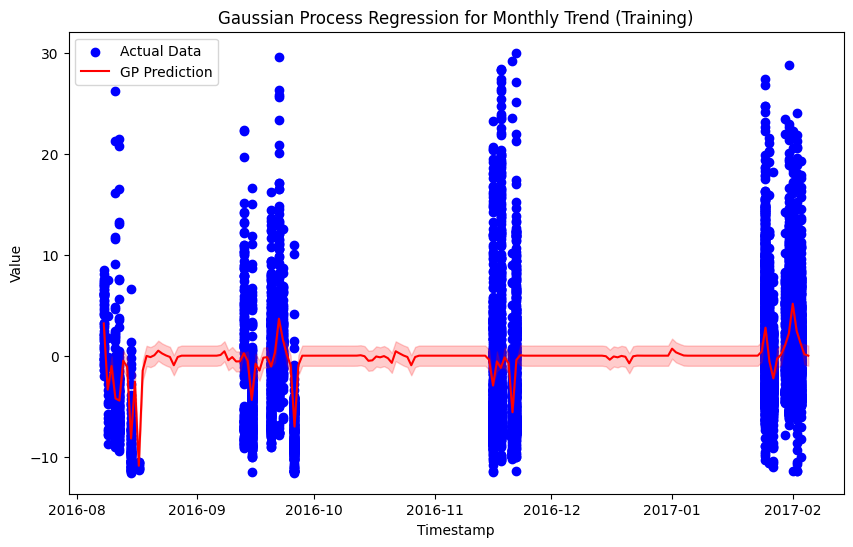

In [ ]:
# Generate predictions for the entire year
train_dates = pd.date_range(start='2016-08-08', end='2017-02-05', freq='D')
train_X = np.column_stack((train_dates.month, train_dates.day))
y_pred, sigma = gp.predict(train_X, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_train['date'], df_train['residual_from_global_mean'], label='Actual Data', color='blue')
plt.plot(train_dates, y_pred, label='GP Prediction', color='red')
plt.fill_between(train_dates, y_pred - sigma, y_pred + sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression for Monthly Trend (Training)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [40]:
# Predict on validation data
y_val_pred, sigma = gp.predict(X_val, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_val_pred)

print("Mean Squared Error (validation):", mse)

Mean Squared Error (validation): 36.478646306630935


In [44]:
y_pred

array([ 1.53498831e-08,  1.27547712e-14,  1.94385021e-22, -1.26087098e-31,
       -5.49499410e-32, -2.27488438e-31, -2.39000383e-31, -2.89128352e-32,
       -5.64088706e-32, -4.16468056e-31, -1.35596377e-31, -5.85793739e-31])

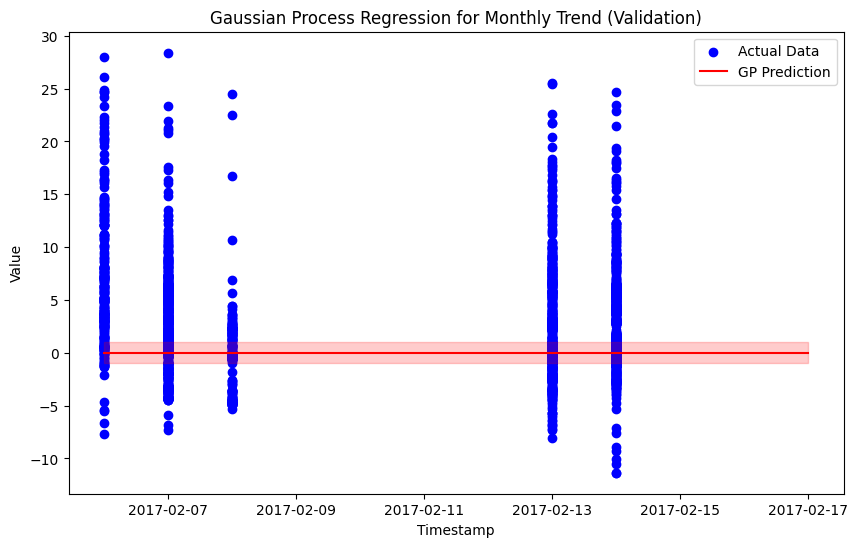

In [46]:
# Generate predictions for the entire year
val_dates = pd.date_range(start='2017-02-06', end='2017-02-17', freq='D')
val_X = np.column_stack((val_dates.month, val_dates.day))
y_pred, sigma = gp.predict(val_X, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_val['date'], df_val['residual_from_global_mean'], label='Actual Data', color='blue')
plt.plot(val_dates, y_pred, label='GP Prediction', color='red')
plt.fill_between(val_dates, y_pred - sigma, y_pred + sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression for Monthly Trend (Validation)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

#### Option 2: Matern

In [35]:
gp = GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=0.5, length_scale_bounds="fixed"), random_state=42)
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=0.5),
                         random_state=42)

In [36]:
# Predict on training data
y_train_pred, sigma = gp.predict(X_train, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_train_pred)

print("Mean Squared Error (training):", mse)

Mean Squared Error (training): 27.62793607086735


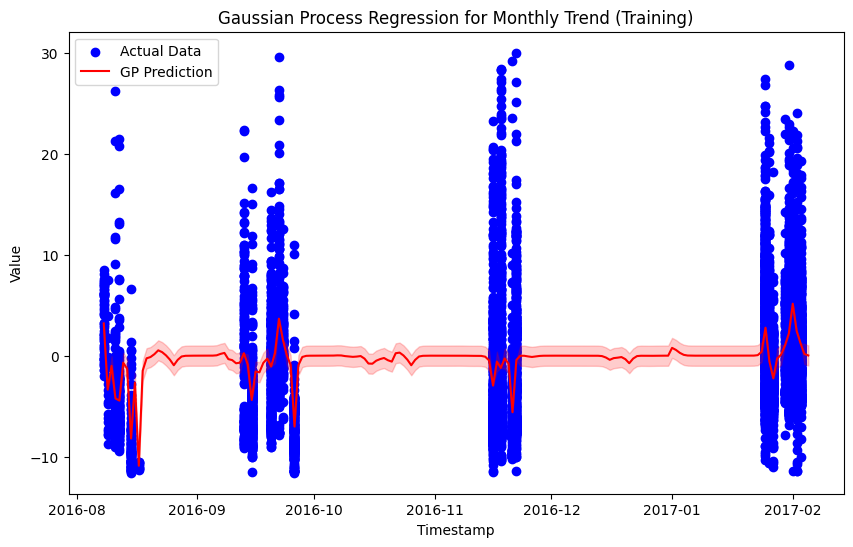

In [37]:
# Generate predictions for the entire year
train_dates = pd.date_range(start='2016-08-08', end='2017-02-05', freq='D')
train_X = np.column_stack((train_dates.month, train_dates.day))
y_pred, sigma = gp.predict(train_X, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_train['date'], df_train['residual_from_global_mean'], label='Actual Data', color='blue')
plt.plot(train_dates, y_pred, label='GP Prediction', color='red')
plt.fill_between(train_dates, y_pred - sigma, y_pred + sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression for Monthly Trend (Training)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [38]:
# Predict on validation data
y_val_pred, sigma = gp.predict(X_val, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_val_pred)

print("Mean Squared Error (validation):", mse)

Mean Squared Error (validation): 36.47345710643412


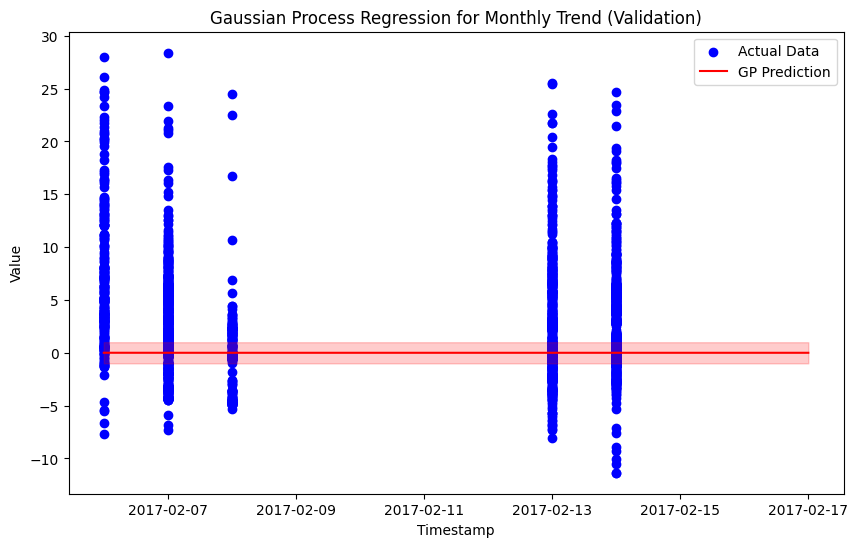

In [39]:
# Generate predictions for the entire year
val_dates = pd.date_range(start='2017-02-06', end='2017-02-17', freq='D')
val_X = np.column_stack((val_dates.month, val_dates.day))
y_pred, sigma = gp.predict(val_X, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_val['date'], df_val['residual_from_global_mean'], label='Actual Data', color='blue')
plt.plot(val_dates, y_pred, label='GP Prediction', color='red')
plt.fill_between(val_dates, y_pred - sigma, y_pred + sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression for Monthly Trend (Validation)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

### Try plotting the whole sequence

In [48]:
df_train = df_train.set_index('datetime')
X_train = np.array(df_train.index).astype(np.int64).reshape(-1, 1)   #converting the timestamps nanoseconds since the epoch, which is January 1, 1970. 
y_train = df_train['residual_from_global_mean'].values.reshape(-1, 1)

In [49]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.5, length_scale_bounds="fixed"), random_state=42)
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=0.5), random_state=42)

In [50]:
# Predict on training data
y_train_pred, sigma = gp.predict(X_train, return_std=True)

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_train_pred)

print("Mean Squared Error (training):", mse)

Mean Squared Error (training): 3.7782883468967583e-19


/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_66876/2971575044.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X_pred, y_pred, 'k', label='GP Prediction', color='red')


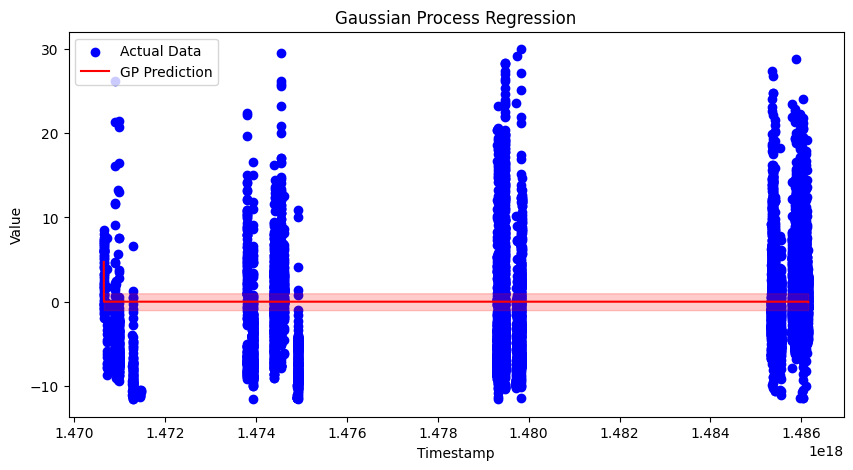

In [54]:
X_pred = np.linspace(X_train.min(), X_train.max(), 10000).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_pred, y_pred, 'k', label='GP Prediction', color='red')
plt.fill_between(X_pred.ravel(), (y_pred - sigma).ravel(), (y_pred + sigma).ravel(), alpha=0.2, color='red')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

In [32]:
# higher n_restarts_optimizer=1
# gp_opt = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, random_state=42)
# gp_opt.fit(X, y)

/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=3, random_state=42)

In [33]:
# # Predict on training data
# y_train_pred_opt, sigma = gp_opt.predict(X, return_std=True)

# # Calculate Mean Squared Error
# mse = mean_squared_error(y, y_train_pred_opt)

# print("Mean Squared Error of opt:", mse)

/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


Mean Squared Error of opt: 31.07275141865826


/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


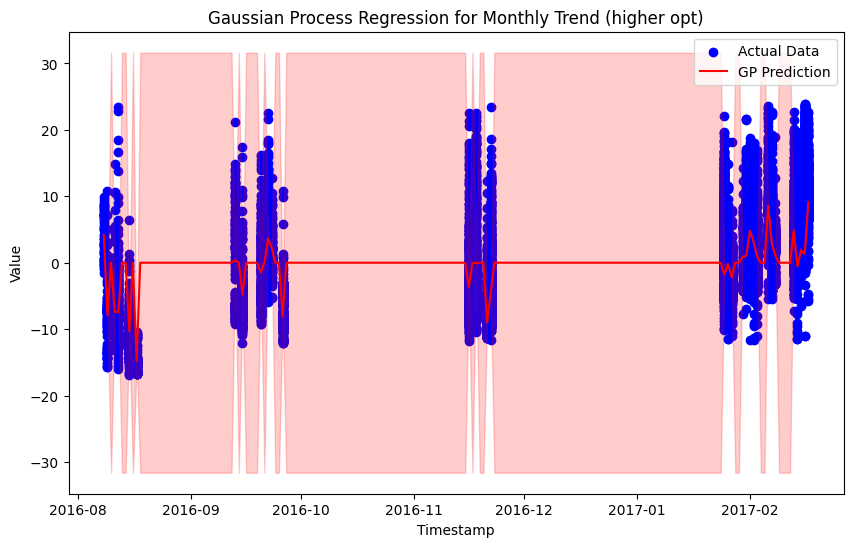

In [34]:
# # Generate predictions for the entire year
# new_dates = pd.date_range(start='2016-08-08', end='2017-02-17', freq='D')
# new_X = np.column_stack((new_dates.month, new_dates.day))
# y_pred, sigma = gp_opt.predict(new_X, return_std=True)

# # Plot the original data and the GP predictions
# plt.figure(figsize=(10, 6))
# plt.scatter(df_NO2['date'], df_NO2['residual_from_global_mean'], label='Actual Data', color='blue')
# plt.plot(new_dates, y_pred, label='GP Prediction', color='red')
# plt.fill_between(new_dates, y_pred - sigma, y_pred + sigma, alpha=0.2, color='red')
# plt.title('Gaussian Process Regression for Monthly Trend (higher opt)')
# plt.xlabel('Timestamp')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [54]:
# kernel = C(1.0, (1e-5, 1e5)) * RBF(1.0, (1e-4, 1e4))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, random_state=42)
# gp.fit(X, y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=1, random_state=42)

In [55]:
# # Predict on training data
# y_train_pred_opt, sigma = gp_opt.predict(X, return_std=True)

# # Calculate Mean Squared Error
# mse = mean_squared_error(y, y_train_pred_opt)

# print("Mean Squared Error of opt:", mse)

/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


Mean Squared Error of opt: 31.878558361471832


/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


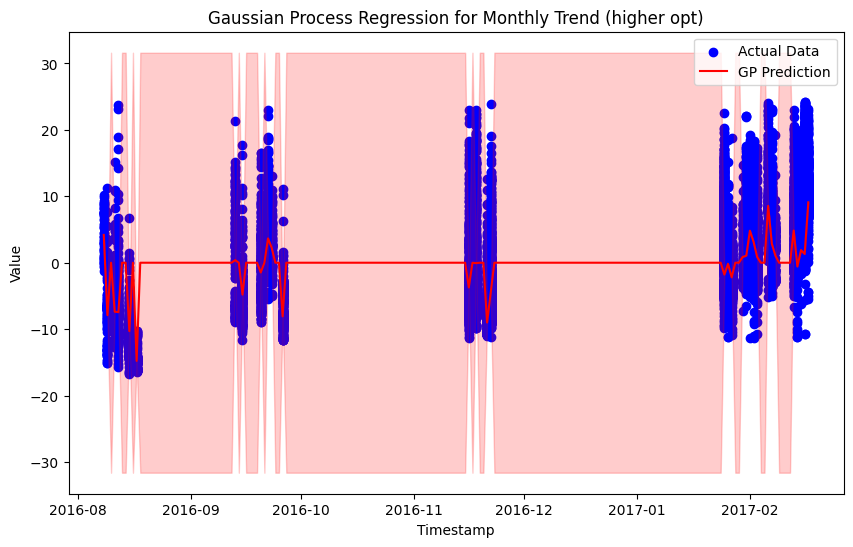

In [56]:
# # Generate predictions for the entire year
# new_dates = pd.date_range(start='2016-08-08', end='2017-02-17', freq='D')
# new_X = np.column_stack((new_dates.month, new_dates.day))
# y_pred, sigma = gp_opt.predict(new_X, return_std=True)

# # Plot the original data and the GP predictions
# plt.figure(figsize=(10, 6))
# plt.scatter(df_NO2['date'], df_NO2['residual_from_global_mean'], label='Actual Data', color='blue')
# plt.plot(new_dates, y_pred, label='GP Prediction', color='red')
# plt.fill_between(new_dates, y_pred - sigma, y_pred + sigma, alpha=0.2, color='red')
# plt.title('Gaussian Process Regression for Monthly Trend (higher opt)')
# plt.xlabel('Timestamp')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [58]:
# # Define the objective function (negative log-likelihood)
# def objective_function(params):
#     kernel = C(params[0], (1e-5, 1e5)) * RBF(params[1], (1e-4, 1e4))
#     gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, random_state=42)
#     gp.fit(X, y)
#     return -gp.log_marginal_likelihood()

# # Initial guess for hyperparameters
# initial_params = [1.0, 1.0]  # You can set this based on your understanding of the problem

# # Perform optimization
# result = minimize(objective_function, initial_params, bounds=((1e-5, 1e5), (1e-4, 1e4)))

# # Get the optimized hyperparameters
# optimized_params = result.x
# print("Optimized hyperparameters:", optimized_params)

/Users/marciama/opt/anaconda3/envs/ptsa_project/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [ ]:
# Create a Gaussian process model with the optimized hyperparameters
# optimized_kernel = C(optimized_params[0], (1e-5, 1e5)) * RBF(optimized_params[1], (1e-4, 1e4))
# optimized_gp = GaussianProcessRegressor(kernel=optimized_kernel, n_restarts_optimizer=0, random_state=42)

# optimized_gp.fit(X, y)
# y_pred, sigma = optimized_gp.predict(X, return_std=True)

# mse = mean_squared_error(y, y_pred)

# print("Mean Squared Error of opt:", mse)